<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Detecting-Silent-Cardiac-Atrial-fibrillation-from-PPG-and-single-lead-ECG-Data-using-CNN-LSTM/blob/master/3.%20LSTM_models_PhysioNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os, os.path
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

import zipfile
import re
import pickle
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM, Activation, Dense, Dropout, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# Preparing the data according to the model Architecture

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# loading the saved dataframe
train_normalised                  = pd.read_pickle('Dataframes/Train_normalised.pkl')
train_normalised_aug              = pd.read_pickle('Dataframes/Train_normalised_aug.pkl')

train_normalised_oversampled      = pd.read_pickle('Dataframes/train_normalised_oversampled.pkl')
train_normalised_aug_oversampled  = pd.read_pickle('Dataframes/train_normalised_aug_oversampled.pkl')

test_normalised                   = pd.read_pickle('Dataframes/Test_normalised.pkl')

### Function to prepare train, test and validation data

In [ ]:
def prepare_data(train_set, test_set, test_prop = 0.3):

  # splitting the data into test and validation set
  val_set, test_set = train_test_split(test_set, test_size=test_prop, random_state=42, shuffle=True)
  
  test_set.reset_index(drop=True, inplace=True)
  val_set.reset_index(drop=True, inplace=True)

  # Splitting into input and output variables
  X_train = train_set.signals
  Y_train = train_set.output_label

  X_test = test_set.signals
  Y_test = test_set.output_label

  X_val = val_set.signals
  Y_val = val_set.output_label

  #####
  input_train   = np.zeros((len(X_train), 9000), dtype='float32')
  output_train = np.zeros(len(Y_train), dtype='float32')

  input_test   = np.zeros((len(X_test), 9000), dtype='float32')
  output_test = np.zeros(len(Y_test), dtype='float32')

  input_val   = np.zeros((len(X_val), 9000), dtype='float32')
  output_val = np.zeros(len(Y_val), dtype='float32')

  # modeling X input
  for index, value in enumerate(X_train):
    input_train[index] = value[0]


  for index, value in enumerate(X_test):
    input_test[index] = value[0]


  for index, value in enumerate(X_val):
    input_val[index] = value[0]

  
  # class 0 = Normal, class 1 = Afib
  # modeling Y output
  for index,value in enumerate(Y_train):
    if(value == 'N'):
      output_train[index] = 0
    else:
      output_train[index] = 1

  # modeling Y output
  for index,value in enumerate(Y_test):
    if(value == 'N'):
      output_test[index] = 0
    else:
      output_test[index] = 1

  # modeling Y output
  for index,value in enumerate(Y_val):
    if(value == 'N'):
      output_val[index] = 0
    else:
      output_val[index] = 1

  ## expanding the dimensions
  input_train = input_train.reshape(len(input_train), 9000, 1)
  output_train = output_train.reshape(len(output_train), 1)

  input_test = input_test.reshape(len(input_test), 9000, 1)
  output_test = output_test.reshape(len(output_test), 1)

  input_val = input_val.reshape(len(input_val), 9000, 1)
  output_val = output_val.reshape(len(output_val), 1)

  ## return the data
  return (input_train, output_train, input_test, output_test, input_val, output_val)



# 1. Models without Oversampling Technique 

## 1.1 Model using Normal data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = prepare_data(train_normalised, test_normalised, 0.3)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

input train shape:	  (3975, 9000, 1)
output train shape:	  (3975, 1)

input test shape:	  (504, 9000, 1)
output test shape:	  (504, 1)

input val shape:	  (1176, 9000, 1)
output val shape:	  (1176, 1)


### 1.1.1 MODEL 1

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

# class_weight_dict = dict(enumerate(class_weights))

# class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 50
batch_size      = 16

In [ ]:
normal_nooversample_model_1 = Sequential()

input_shape = (9000, 1)
normal_nooversample_model_1.add(InputLayer(input_shape=input_shape))

normal_nooversample_model_1.add(LSTM(64,activation = "tanh", return_sequences = True))
normal_nooversample_model_1.add(Dropout(0.2))
normal_nooversample_model_1.add(LSTM(32, activation = "tanh"))
normal_nooversample_model_1.add(Dropout(0.2))
normal_nooversample_model_1.add(Dense(32, activation='tanh'))
normal_nooversample_model_1.add(BatchNormalization())
normal_nooversample_model_1.add(Dense(1, activation = 'sigmoid'))

normal_nooversample_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9000, 64)          16896     
_________________________________________________________________
dropout (Dropout)            (None, 9000, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [ ]:
# model training configuration 
normal_nooversample_model_1.compile(optimizer = keras.optimizers.Adam(),
                                    loss      = keras.losses.BinaryCrossentropy(),
                                    metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/LSTM Normal data/Model 1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
normal_nooversample_model_1_his = normal_nooversample_model_1.fit(input_train, output_train,
                                                                  batch_size = batch_size , epochs = epochs, 
                                                                  validation_data = (input_val, output_val),
                                                                  # class_weight=class_weight_dict_1,
                                                                  callbacks=[early_stop, reduce_lr,model_save])

Epoch 1/50
249/249 [==============================] - 135s 447ms/step - loss: 0.6144 - binary_accuracy: 0.7077 - val_loss: 0.3640 - val_binary_accuracy: 0.8929
Epoch 2/50
249/249 [==============================] - 110s 442ms/step - loss: 0.3836 - binary_accuracy: 0.8772 - val_loss: 0.3542 - val_binary_accuracy: 0.8929
Epoch 3/50
249/249 [==============================] - 110s 443ms/step - loss: 0.3965 - binary_accuracy: 0.8674 - val_loss: 0.3486 - val_binary_accuracy: 0.8929
Epoch 4/50
249/249 [==============================] - 111s 445ms/step - loss: 0.4043 - binary_accuracy: 0.8625 - val_loss: 0.3443 - val_binary_accuracy: 0.8929
Epoch 5/50
249/249 [==============================] - 111s 445ms/step - loss: 0.3799 - binary_accuracy: 0.8737 - val_loss: 0.3423 - val_binary_accuracy: 0.8929
Epoch 6/50
249/249 [==============================] - 111s 446ms/step - loss: 0.4032 - binary_accuracy: 0.8606 - val_loss: 0.3519 - val_binary_accuracy: 0.8929
Epoch 7/50
249/249 [====================

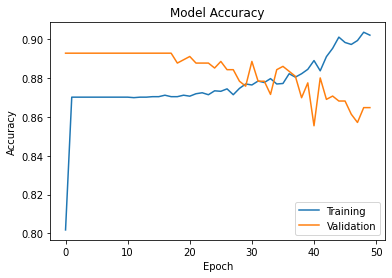

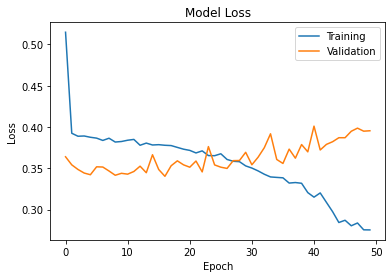

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = normal_nooversample_model_1_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
# model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 1/ECG.epoch_29.TL_0.2979.VL_0.3098.TA_0.89.VA_0.90.hdf5')

model = normal_nooversample_model_1

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

Test loss: 0.4905490279197693
Test accuracy: 0.8194444179534912


In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


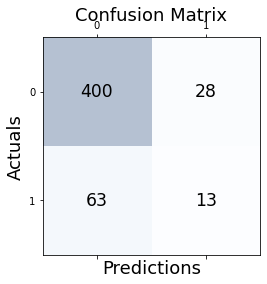

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

Accuracy:		 0.8194
Precision:		 0.3171
Recall: 		 0.1711
F1 score:		 0.2222


### 1.1.2 MODEL 2

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.5745880312228968, 1: 3.8517441860465116}

In [ ]:
# Defining parameter values
epochs          = 60
batch_size      = 16

In [ ]:
normal_nooversample_model_2 = Sequential()

input_shape = (9000, 1)
normal_nooversample_model_2.add(InputLayer(input_shape=input_shape))

normal_nooversample_model_2.add(LSTM(64,activation = "tanh", return_sequences = True))
normal_nooversample_model_2.add(LSTM(32, activation = "tanh", return_sequences = True))
normal_nooversample_model_2.add(LSTM(16, activation = "tanh"))

normal_nooversample_model_2.add(Dropout(0.2))
normal_nooversample_model_2.add(Dense(32, activation='tanh'))
normal_nooversample_model_2.add(BatchNormalization())
normal_nooversample_model_2.add(Dense(1, activation = 'sigmoid'))

normal_nooversample_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 9000, 64)          16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 9000, 32)          12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
# model training configuration 
normal_nooversample_model_2.compile(optimizer = keras.optimizers.Adam(),
                                    loss      = keras.losses.BinaryCrossentropy(),
                                    metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/LSTM Normal data/Model 2/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
normal_nooversample_model_2_his = normal_nooversample_model_2.fit(input_train, output_train,
                                                                  batch_size = batch_size , epochs = epochs, 
                                                                  validation_data = (input_val, output_val),
                                                                  class_weight=class_weight_dict,
                                                                  callbacks=[early_stop, reduce_lr,model_save])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/60
249/249 [==============================] - 164s 643ms/step - loss: 0.7102 - binary_accuracy: 0.5138 - val_loss: 0.7366 - val_binary_accuracy: 0.3793
Epoch 2/60
249/249 [==============================] - 158s 634ms/step - loss: 0.6913 - binary_accuracy: 0.4978 - val_loss: 0.8449 - val_binary_accuracy: 0.2491
Epoch 3/60
249/249 [==============================] - 159s 637ms/step - loss: 0.7023 - binary_accuracy: 0.5038 - val_loss: 0.6444 - val_binary_accuracy: 0.7330
Epoch 4/60
249/249 [==============================] - 158s 635ms/step - loss: 0.7005 - binary_accuracy: 0.5235 - val_loss: 0.6150 - val_binary_accuracy: 0.7730
Epoch 5/60
249/249 [==============================] - 158s 635ms/step - loss: 0.6913 - binary_accuracy: 0.5277 - val_loss: 0.6892 - val_binary_accuracy: 0.5094
Epoch 6/60
249/249 [==============================] - 159s 638

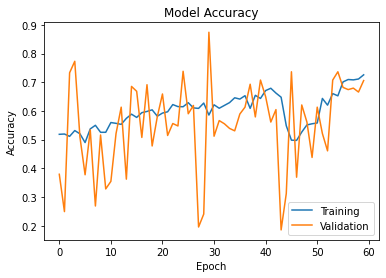

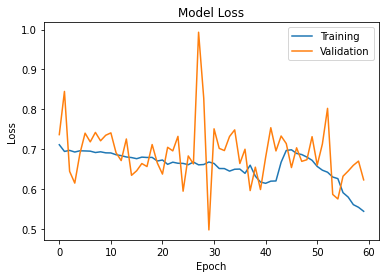

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = normal_nooversample_model_2_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
# model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 2/ECG.epoch_16.TL_0.6650.VL_0.3874.TA_0.59.VA_0.89.hdf5')

model = normal_nooversample_model_2

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

Test loss: 0.6525382995605469
Test accuracy: 0.682539701461792


In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


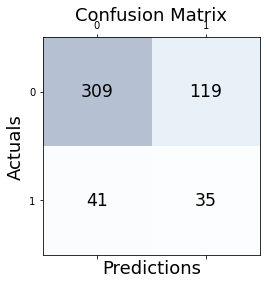

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

Accuracy:		 0.6825
Precision:		 0.2273
Recall: 		 0.4605
F1 score:		 0.3043


### 1.1.3 MODEL 3

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

class_weight_dict_1 = {0: 1.0, 1: 8.0}

class_weight_dict_1

{0: 1.0, 1: 8.0}

In [ ]:
# Defining parameter values
epochs          = 50
batch_size      = 16

In [ ]:
normal_nooversample_model_3 = Sequential()

input_shape = (9000, 1)
normal_nooversample_model_3.add(InputLayer(input_shape=input_shape))

normal_nooversample_model_3.add(LSTM(32,activation = "tanh", return_sequences = True))
normal_nooversample_model_3.add(LSTM(16,activation = "tanh", return_sequences = True))
normal_nooversample_model_3.add(LSTM(8, activation = "tanh"))

normal_nooversample_model_3.add(Dropout(0.2))

normal_nooversample_model_3.add(Dense(32, activation='tanh'))
normal_nooversample_model_3.add(BatchNormalization())
normal_nooversample_model_3.add(Dense(1, activation = 'sigmoid'))

normal_nooversample_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 9000, 32)          4352      
_________________________________________________________________
lstm_9 (LSTM)                (None, 9000, 16)          3136      
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                288       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
# model training configuration 
normal_nooversample_model_3.compile(optimizer = keras.optimizers.Adam(),
                                    loss      = keras.losses.BinaryCrossentropy(),
                                    metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 40, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/LSTM Normal data/Model 3/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
normal_nooversample_model_3_his = normal_nooversample_model_3.fit(input_train, output_train,
                                                                  batch_size = batch_size , epochs = epochs, 
                                                                  validation_data = (input_val, output_val),
                                                                  class_weight=class_weight_dict_1,
                                                                  callbacks=[early_stop, reduce_lr,model_save])

Epoch 1/50
249/249 [==============================] - 154s 602ms/step - loss: 1.3723 - binary_accuracy: 0.4224 - val_loss: 0.8132 - val_binary_accuracy: 0.1122
Epoch 2/50
249/249 [==============================] - 147s 590ms/step - loss: 1.3370 - binary_accuracy: 0.3115 - val_loss: 0.8631 - val_binary_accuracy: 0.1148
Epoch 3/50
249/249 [==============================] - 148s 593ms/step - loss: 1.2934 - binary_accuracy: 0.3398 - val_loss: 0.7944 - val_binary_accuracy: 0.1293
Epoch 4/50
249/249 [==============================] - 147s 590ms/step - loss: 1.3369 - binary_accuracy: 0.3179 - val_loss: 0.7259 - val_binary_accuracy: 0.3095
Epoch 5/50
249/249 [==============================] - 149s 600ms/step - loss: 1.3395 - binary_accuracy: 0.3174 - val_loss: 0.7874 - val_binary_accuracy: 0.1071
Epoch 6/50
249/249 [==============================] - 149s 598ms/step - loss: 1.3360 - binary_accuracy: 0.3037 - val_loss: 0.7916 - val_binary_accuracy: 0.1071
Epoch 7/50
249/249 [====================

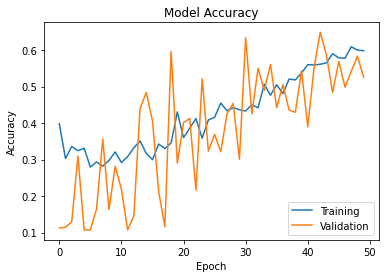

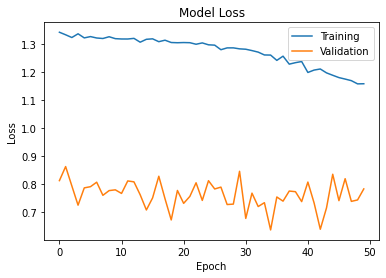

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = normal_nooversample_model_3_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
model = normal_nooversample_model_3

test_scores = normal_nooversample_model_3.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650


# # Load the Final model
# model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 3/ECG.epoch_87.TL_0.2068.VL_0.2261.TA_0.95.VA_0.94.hdf5')

# test_scores = model.evaluate(input_test, output_test, verbose = 0)
# print("Test loss:", test_scores[0])               # 0.1305         
# print("Test accuracy:", test_scores[1])           # 0.9650

Test loss: 0.7791268825531006
Test accuracy: 0.5496031641960144


In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


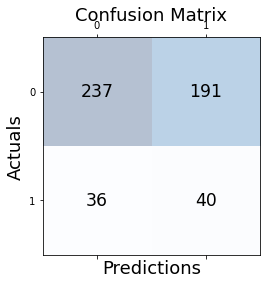

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

Accuracy:		 0.5496
Precision:		 0.1732
Recall: 		 0.5263
F1 score:		 0.2606


## 1.2 Model using Augmented data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = prepare_data(train_normalised_aug, test_normalised, 0.20)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

input train shape:	  (4334, 9000, 1)
output train shape:	  (4334, 1)

input test shape:	  (336, 9000, 1)
output test shape:	  (336, 1)

input val shape:	  (1344, 9000, 1)
output val shape:	  (1344, 1)


### 1.2.1 MODEL 1

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

# class_weight_dict = dict(enumerate(class_weights))

# class_weight_dict

# class_weight_dict_1 = {0: 1.0, 1: 8.0}

# class_weight_dict_1

In [ ]:
# # Defining parameter values
# epochs          = 200
# batch_size      = 16

In [ ]:
# aug_nooversample_model_1 = Sequential()

# # 64, 64, 32, 16, 8, 32

# input_shape = (9000, 1)
# aug_nooversample_model_1.add(InputLayer(input_shape=input_shape))

# aug_nooversample_model_1.add(Conv1D(64, 2,padding='causal', activation="tanh"))
# aug_nooversample_model_1.add(MaxPooling1D(2))

# aug_nooversample_model_1.add(Conv1D(64, 2,padding='same', activation="tanh"))
# aug_nooversample_model_1.add(MaxPooling1D(2))

# aug_nooversample_model_1.add(LSTM(32,activation = "tanh", return_sequences = True))
# aug_nooversample_model_1.add(LSTM(16, activation = "tanh", return_sequences = True))
# aug_nooversample_model_1.add(LSTM(8, activation = "tanh"))

# aug_nooversample_model_1.add(Dense(32, activation='tanh'))
# aug_nooversample_model_1.add(BatchNormalization())
# aug_nooversample_model_1.add(Dense(1, activation = 'sigmoid'))

# aug_nooversample_model_1.summary()

In [ ]:
# # model training configuration 
# aug_nooversample_model_1.compile(optimizer = keras.optimizers.Adam(),
#                                     loss      = keras.losses.BinaryCrossentropy(),
#                                     metrics   = [keras.metrics.BinaryAccuracy()])

# #SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# # Callback to reduce the learning rate when the validation loss has stopped improving
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 30, mode = 'min')

# # Callback to stop training the model when the validation loss has stopped improving
# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min')

# # CHECKPOINT callback
# filepath = "Training_models/CNN-LSTM Normal data/Model 4/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# # Save training model when there is an improvement in validation_accuracy from the previous checkpint
# model_save = keras.callbacks.ModelCheckpoint(filepath, 
#                                              monitor = 'val_binary_accuracy',
#                                              save_best_only=True, 
#                                              mode = 'max')




In [ ]:
# # Fitting the model
# aug_nooversample_model_1_his = aug_nooversample_model_1.fit(input_train, output_train,
#                                                                   batch_size = batch_size , epochs = epochs, 
#                                                                   validation_data = (input_val, output_val),
#                                                                   class_weight=class_weight_dict_1,
#                                                                   callbacks=[early_stop, reduce_lr,model_save])

# aug_nooversample_model_1.save('Training_models/CNN-LSTM Normal data/Model 4/ECG.final_run.hdf5')

Model Evaluation

In [ ]:
# Load the last checkpoint model
model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4/ECG.epoch_70.TL_0.3511.VL_0.1512.TA_0.91.VA_0.95.hdf5')

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:\t", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

# Load the final model
model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4/ECG.final_run.hdf5')

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("\nTest loss:\t", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

Test loss:	 0.1882288008928299
Test accuracy: 0.9166666865348816

Test loss:	 0.2945140600204468
Test accuracy: 0.9226190447807312


In [ ]:
# # training more
# aug_nooversample_model_1 = load_model('Training_models/CNN-LSTM Normal data/Model 4/ECG.final_run.hdf5')

# # model training configuration 
# aug_nooversample_model_1.compile(optimizer = keras.optimizers.Adam(),
#                                     loss      = keras.losses.BinaryCrossentropy(),
#                                     metrics   = [keras.metrics.BinaryAccuracy()])

# #SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# # Callback to reduce the learning rate when the validation loss has stopped improving
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 30, mode = 'min')

# # Callback to stop training the model when the validation loss has stopped improving
# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min')

# # CHECKPOINT callback
# filepath = "Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# # Save training model when there is an improvement in validation_accuracy from the previous checkpint
# model_save = keras.callbacks.ModelCheckpoint(filepath, 
#                                              monitor = 'val_binary_accuracy',
#                                              save_best_only=True, 
#                                              mode = 'max')


# # Fitting the model
# aug_nooversample_model_1_his = aug_nooversample_model_1.fit(input_train, output_train,
#                                                                   batch_size = batch_size , epochs = epochs, 
#                                                                   validation_data = (input_val, output_val),
#                                                                   class_weight=class_weight_dict_1,
#                                                                   callbacks=[early_stop, reduce_lr,model_save])

# aug_nooversample_model_1.save('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.final_run.hdf5')


In [ ]:
# # Load the last checkpoint model
# model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')

# test_scores = model.evaluate(input_test, output_test, verbose = 0)
# print("Test loss:\t", test_scores[0])               # 0.1305         
# print("Test accuracy:", test_scores[1])           # 0.9650

# # Load the final model
# model_1 = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.final_run.hdf5')

# test_scores = model_1.evaluate(input_test, output_test, verbose = 0)
# print("\nTest loss:\t", test_scores[0])               # 0.1305         
# print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
# yhat = model_1.predict_classes(input_test)

# conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# # Print the confusion matrix using Matplotlib

# fig, ax = plt.subplots()
# ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

In [ ]:
# accuracy = accuracy_score(output_test, yhat)
# print('Accuracy:\t\t', round(accuracy,4))

# # precision tp / (tp + fp)
# precision = precision_score(output_test, yhat)
# print('Precision:\t\t', round(precision,4))

# # recall: tp / (tp + fn)
# recall = recall_score(output_test, yhat)
# print('Recall: \t\t', round(recall,4))

# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(output_test, yhat)
# print('F1 score:\t\t', round(f1,4))